# Sequence Level Features and Analysis

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ttest_1samp, poisson
from Bio import pairwise2
from Bio.pairwise2 import format_alignment


pd.set_option('display.float_format', '{:.10e}'.format)
pd.set_option('display.max_colwidth', 30)

ModuleNotFoundError: No module named 'Bio'

In [43]:
csv_file = "../Data/R12-clean.csv"
df = pd.read_csv(csv_file)
df.head(5)

,Sequence,Copy Num,Length
0,AGTGCCATCGTGCGTATCCTTCACTC...,91,98
1,AGTGCCATCGTGCGTATCCTTCACGT...,86,98
2,AGTGCCATCGTGCGTATCCTGAACAT...,83,98
3,AGTGCCATCGTGCGTATCCCGCTCCG...,80,98
4,AGTGCCATCGTGCGTATCCTGAACAT...,78,98


### 1. Base Composition

In [44]:
# Ratio of GC to AT content
def GC_content(sequence):
    count = Counter(sequence)
    return (count['G'] + count['C'])/len(sequence)

In [45]:
df['GC content'] = df['Sequence'].apply(GC_content)

In [46]:
mean_GC = np.mean(df['GC content'])
median_GC = np.median(df['GC content'])
print(f'Mean: {np.round(mean_GC, 5)}\nMedian: {np.round(median_GC, 5)}')

Mean: 0.53351
Median: 0.53061


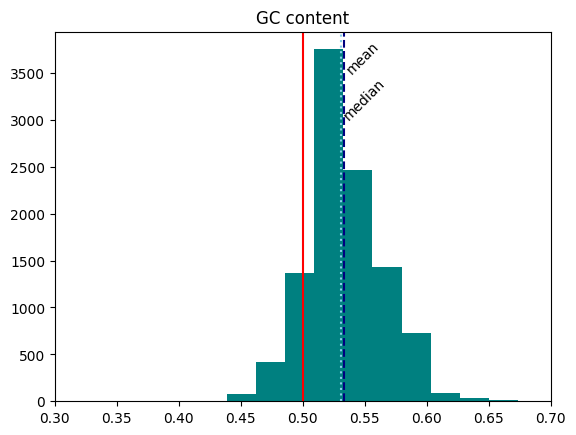

In [47]:
plt.hist(df['GC content'], color= 'teal')
plt.title('GC content')
plt.xlim(0.3, 0.7)
plt.axvline(x=0.5, color='red')
# show mean and median lines
plt.axvline(x=mean_GC, color='navy', linestyle='--', label='Mean')
plt.axvline(x=median_GC, color='skyblue', linestyle='dotted', label='Median')
plt.text(mean_GC, 3500, 'mean', rotation=45)
plt.text(median_GC, 3000, 'median', rotation=45)
plt.show()

In [48]:
np.sum(df['GC content'] > 0.5)/len(df['GC content'])

0.8247134739477993

Interestingly, the GC content seems to skew left.  An unbiased set of sequences might expect the GC% to be around 0.5, but we can see a majority of sequences have higher than expected GC content. In fact, about 82.5% of the sequences have higher than 50% GC content. Specific motifs or structural elements that are GC-rich may have been selected.  GC rich sequences often form more stable secondary structures.

#### a. One sample t-test

In [49]:
t_stat, p_val = ttest_1samp(df['GC content'], 0.5)
print(f'T-statistic: {t_stat}, P-value: {p_val}')

T-statistic: 110.4588265736308, P-value: 0.0


The GC content being higher is statistically significant.  We cannot be sure of biological importance, however.

### 2. k-mer Frequency  

In [86]:
def extract_kmers(seq, k):
    """Extracts kmers from a sequence. Saves position and kmer chunk to preserve order and distance information for downstream secondary structure analysis. Collects kmers from all k reading frames."""
    all_kmers = [(i, seq[i:i+k]) for i in range(len(seq)-k+1)]
    return all_kmers

In [87]:
def getkmers(data, k):
    kmer_data = []
    for idx, row in df.iterrows():
        kmers = extract_kmers(row['Sequence'], k)
        for position, kmer in kmers:
            kmer_data.append({'Sequence_ID': idx, 'Position': position, 'k-mer': kmer})
    
    kmer_df = pd.DataFrame(kmer_data)
    return kmer_df

In [88]:
getkmers(data=df, k=10).head()

,Sequence_ID,Position,k-mer
0,0,0,AGTGCCATCG
1,0,1,GTGCCATCGT
2,0,2,TGCCATCGTG
3,0,3,GCCATCGTGC
4,0,4,CCATCGTGCG


#### kmer Frequency across enriched pool

In [95]:
# k=10
kmers = getkmers(df, 10)
kmers.head()


,Sequence_ID,Position,k-mer
0,0,0,AGTGCCATCG
1,0,1,GTGCCATCGT
2,0,2,TGCCATCGTG
3,0,3,GCCATCGTGC
4,0,4,CCATCGTGCG


In [96]:
kmers_count = kmers['k-mer'].value_counts()
kmers_count.head()

k-mer
CATCGTGCGT    10384
ATCGTGCGTA    10384
TCGTGCGTAT    10384
GTGCGTATCC    10384
GGAGACACGA    10384
Name: count, dtype: int64

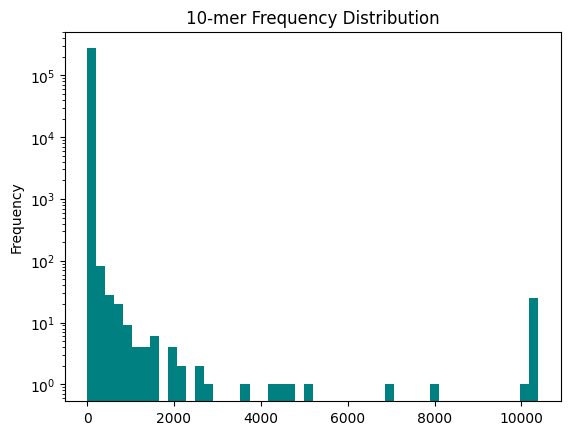

In [97]:
# Plot histogram to get overview of distribution
kmers_count.plot(kind='hist', bins=50, color='teal')
plt.yscale('log')
plt.figsize=(10,6)
plt.title(f'{k}-mer Frequency Distribution')
plt.show()

#### Designed constant regions of selection library: 
The following describes the template of the starting selection library:

forward primer | AAGTGCCATCGTGCGTATCC | 20 bp  
variable region 1 | (N)^22 | 22 bp  
mipomersen loading | GCGAAGCAGACTGAGGC | 17 bp  
variable region 2 | (N)^21 | 21 bp  
reverse primer | GTAGACTGGAGACACGACGA | 20 bp  

kmers which occur in all sequences likely correspond to constant regions. The constant regions will not be excluded from study since they may contribute to the pH-function via interactions with the variable regions. We note that we can proceed with study by masking off sequences with count > 10,000 because the constant regions alone were shown in control studies not to have pH-activity themselves.  We will be able to indirectly pick up on these interactions by finding repeated motifs in the variable regions.

Short kmers may also have high counts because the probability for a random hit goes up and masking high counts will help reduce this effect as well.

In [100]:
# Exclude k-mers from constant regions
mask = kmers_count < 0.9 * len(df)
filtered_kmers = kmers_count[mask]
filtered_kmers

k-mer
CGAAGCAGAC    8008
GACTGAGGCG    6897
TGCGTATCCT    5093
ACTGAGGCGC    4714
GCGAAGCAGA    4497
              ... 
TAGACTCTAT       1
AGACTCTATG       1
GACTCTATGA       1
GCGTTGACCA       1
AACTCTAGTA       1
Name: count, Length: 271611, dtype: int64

What about kmers which have a very low count in the pool? kmers_count < 10, for example. While these are rare kmers, they may have pH-function or they may be noise. For the study, we could focus first on kmers which are repeated often in the pool to search for convergence. 

#### Search mid-range frequency k-mers for possible pH-active motifs

For a start, check out kmers between 2,000 and 8,008 count.  To reconcile, we should perform an alignment against the constant regions to discard artifacts of library design.

In [73]:
# Probability of random kmer occurrence
p_rkmer = (0.25)**k

# Total number of positions across the dataset
npos = len(df) * (np.mean(df['Length']) - k + 1)

# Expectation value
exp_occ = p_rkmer*npos
print(f'Expected Occurrences: {exp_occ:.3e}')

Expected Occurrences: 8.806e-01


A random 10-mer can be expected to occur <1 times in my dataset, so it looks like the minimum cutoff is quite low.  That's good news and may reflect the high sequence variance which persisted into my enriched pool.

In [78]:
minimum = poisson.ppf(0.05, exp_occ)
print(f'Poisson threshold: {minimum:.3e}')

Poisson threshold: 0.000e+00


# HOWEVER
(1) the low threshold may be because the constant regions are not randomly arising
(2) the primer region kmers should not be gated out because they may form part of the pH function

this suggests that constant regions and variable regions should be analyzed in parallel